This notebook is used to compare automatic differentiation with finite difference differentiation at US-Bi1 site.

In [12]:
from functools import partial
from math import floor

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from equinox.internal import ω
import equinox as eqx

from tqdm import tqdm

from jax_canveg.physics.energy_fluxes import get_dispersion_matrix
from jax_canveg.models import CanvegIFT
from jax_canveg.models import get_canle, update_canle, get_cannee, update_cannee
from jax_canveg.models import get_canlenee, update_canlenee
from jax_canveg.subjects import get_met_forcings, initialize_parameters
from jax_canveg.subjects import convert_met_to_batched_met
from jax_canveg.shared_utilities import tune_jax_naninfs_for_debug
from jax_canveg.shared_utilities.plot import (
    get_time,
    plot_timeseries,
    plot_dij,
    plot_imshow2,
)

import matplotlib.pyplot as plt

# import matplotlib.colors as mcolors

jax.config.update("jax_enable_x64", True)
tune_jax_naninfs_for_debug(False)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model parameters and settings

In [2]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 1
leafrh = 0
soilresp = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 50

batch_size = None

site = "US-Bi1"
key = "purephysics"

# Calibration period
f_forcing = f"../data/fluxtower/{site}/{site}-forcings.csv"

# Load and set the model forcings

In [3]:
# Truncate the forcing data
n_time = 1000
met, _ = get_met_forcings(f_forcing)
met = jtu.tree_map(lambda x: x[:n_time], met)
if batch_size is None:
    batch_size = n_time
n_batch = floor(n_time / batch_size)
batched_met = convert_met_to_batched_met(met, n_batch, batch_size)
timesteps = get_time(met)

In [4]:
# plt.plot(met.soilmoisture)

# Create the model parameter instance

In [5]:
setup, para, para_min, para_max = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    leafrh=leafrh,
    soilresp=soilresp,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    obs=None,
    met=met,
    niter=niter,
    get_para_bounds=True,
)

# Generate or read the dispersion matrix

<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

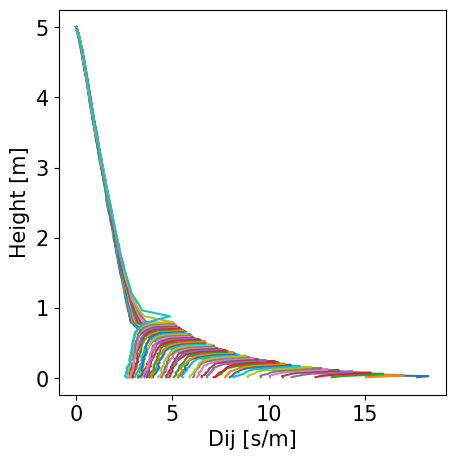

In [6]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, f"../data/dij/Dij_{site}.csv")
plot_dij(dij, para)

# Run CanVeg!

In [7]:
jax.clear_caches()
canveg_eqx_ift = CanvegIFT(para, setup, dij)

states, drivers = canveg_eqx_ift(met)
met, prof, ir, qin, sun, shade, soil, veg, can = states
quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canveg/shared_utilities/plot.py:131: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, ha="right")


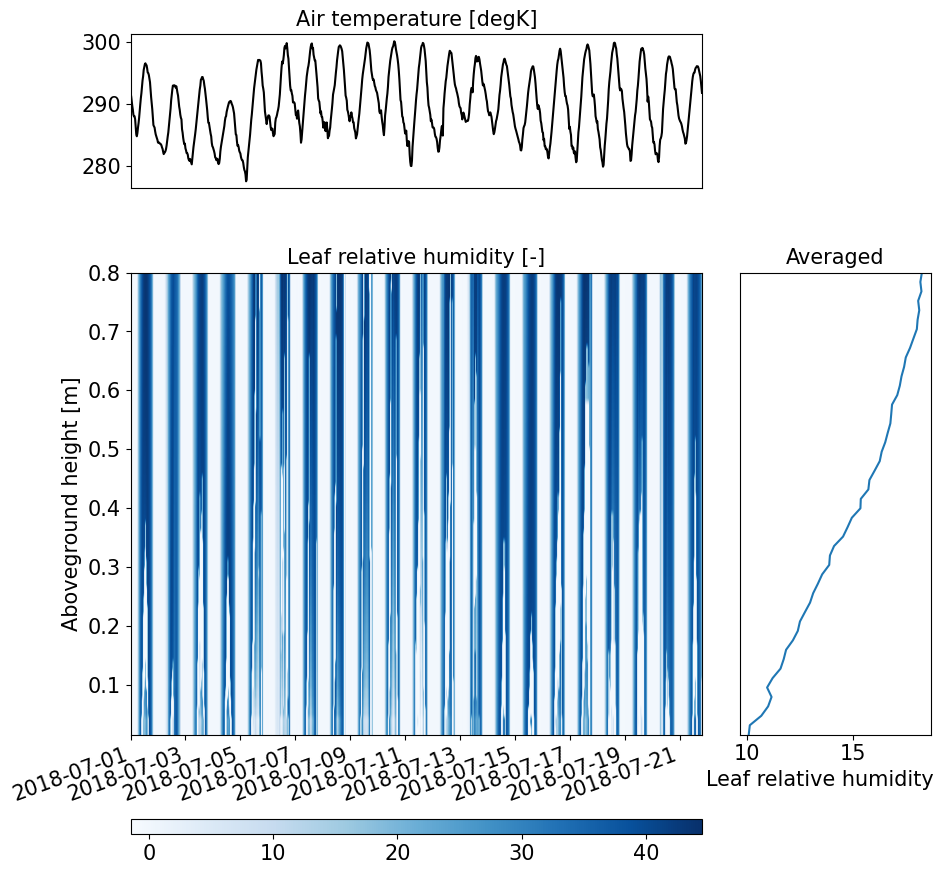

In [8]:
# Leaf relative humidity
plot_imshow2(
    # sun.Leaf_RH.T,
    sun.Ps.T,
    met,
    para.zht1,
    key="T",
    title="Leaf relative humidity [-]",
    cmap="Blues",
);

In [9]:
# Debug CanVeg
@eqx.filter_jit
def func(met, canveg_eqx):
    # Compute out and tangents
    # canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    # out = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)
    out = canveg_eqx(met)
    # tangents = df_canveg_le(para, met, canveg_eqx)
    # tangents_bprime = tangents.bprime
    return out


jax.clear_caches()
func(met, canveg_eqx_ift)

([Met(
    zL=f64[1000],
    year=f64[1000],
    day=f64[1000],
    hhour=f64[1000],
    T_air=f64[1000],
    rglobal=f64[1000],
    eair=f64[1000],
    wind=f64[1000],
    CO2=f64[1000],
    P_kPa=f64[1000],
    ustar=f64[1000],
    Tsoil=f64[1000],
    soilmoisture=f64[1000],
    zcanopy=f64[1000],
    lai=f64[1000]
  ),
  Prof(
    co2=f64[1000,100],
    Tair_K=f64[1000,100],
    Told_K=f64[1000,100],
    eair_Pa=f64[1000,100],
    eair_old_Pa=f64[1000,100],
    wind=f64[1000,50],
    Tsfc=f64[1000,50],
    H=f64[1000,50],
    LE=f64[1000,50],
    Rnet=f64[1000,50],
    Ps=f64[1000,50]
  ),
  Ir(
    ir_in=f64[1000],
    ir_dn=f64[1000,51],
    ir_up=f64[1000,51],
    IR_source_sun=f64[1000,50],
    IR_source_shade=f64[1000,50],
    IR_source=f64[1000,50],
    shade=f64[1000,50],
    shade_top=f64[1000,51],
    shade_bottom=f64[1000,51],
    balance=f64[1000,50]
  ),
  Qin(sun_abs=f64[1000,50], shade_abs=f64[1000,50]),
  SunShadedCan(
    Ps=f64[1000,50],
    Resp=f64[1000,50],
    

# Partial and directional derivatives

In [10]:
# Convert met to batched dataset
batched_met_sa = convert_met_to_batched_met(met, n_time, 1)

In [13]:
# Define directional vector for the parameters of interest
def get_partial_directional_vector(subpara):
    para_tangents = jtu.tree_map(lambda _: 0.0, para)
    para_tangents = eqx.tree_at(
        lambda t: tuple(getattr(t, p) for p in subpara),
        para,
        replace=tuple(True for _ in subpara),
    )
    return para_tangents


subpara = [
    "bprime",
    "ep",
    "lleaf",
    "qalpha",
    "kball",
    "leaf_clumping_factor",
    "vcopt",
    "jmopt",
    "rd25",
    "toptvc",
    "toptjm",
    "epsoil",
    "par_reflect",
    "par_trans",
    "par_soil_refl",
    "nir_reflect",
    "nir_trans",
    "nir_soil_refl",
    "q10a",
    "q10b",
    "q10c",
]
para_tangents = get_partial_directional_vector(subpara)

# The functions for updating and getting substates for derivative evaluation
# update_get_funcs = [[update_canle, get_canle], [update_cannee, get_cannee]]
# update_get_labels = ['LE', 'NEE']
update_get_funcs = [[update_canlenee, get_canlenee]]
update_get_labels = ["LENEE"]

# subpara_set = [['bprime', 'ep', 'lleaf', 'qalpha', 'kball', 'leaf_clumping_factor',
#                 'vcopt', 'jmopt', 'rd25', 'toptvc', 'toptjm',
#                 'par_reflect', 'par_trans', 'par_soil_refl', 'nir_reflect', 'nir_trans', 'nir_soil_refl',
#                 ]]
# # subpara_set = [['bprime'], ['ep'], ['lleaf'], ['qalpha'], ['kball'], ['leaf_clumping_factor']]
# para_tangents_set = [get_partial_directional_vector(subpara) for subpara in subpara_set]

In [14]:
# @jax.jit
@eqx.filter_jit
def tree_dot(a, b):
    """
    Computes the dot product of two pytrees
    Args:
        a, b: pytrees with the same treedef
    Returns:
        A scalar equal the dot product of of the flattened arrays of a and b.
    """
    return jax.tree_util.tree_reduce(
        jax.numpy.add,
        jax.tree_util.tree_map(
            jax.numpy.sum, jax.tree_util.tree_map(jax.numpy.multiply, a, b)
        ),
    )

## AD

In [15]:
# @eqx.filter_jit
# @partial(jax.jacfwd, argnums=0)
# def df_canveg_jac(para, met, canveg_eqx, update_func, get_func):
#     canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
#     can_le, can_nee = canveg_eqx.get_fixed_point_states(met, update_func, get_func)
#     return can_le, can_nee
# # df_canveg_jac(para, met, canveg_eqx_ift, update_canlenee, get_canlenee)
# # canveg_eqx_ift.get_fixed_point_states(met, update_canlenee, get_canlenee)

In [15]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canveg(para, met, canveg_eqx, update_func, get_func):
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    can_le = canveg_eqx.get_fixed_point_states(met, update_func, get_func)
    return can_le.sum()


def AD_directional_derivative(
    para, met, canveg_eqx, para_tangents, update_func, get_func
):
    gradient = df_canveg(para, met, canveg_eqx, update_func, get_func)
    dir_grad = tree_dot(gradient, para_tangents)
    return dir_grad


@eqx.filter_jit
def AD_directional_derivative_batched(
    para, batched_met, canveg_eqx, para_tangents, update_func, get_func
):
    def compute_grad(para, met):
        grad = AD_directional_derivative(
            para, met, canveg_eqx, para_tangents, update_func, get_func
        )
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients

In [16]:
dir_grad_ad_set = []
for funcs in tqdm(update_get_funcs):
    update_func, get_func = funcs[0], funcs[1]
    dir_grad_ad = AD_directional_derivative_batched(
        para, batched_met_sa, canveg_eqx_ift, para_tangents, update_func, get_func
    )
    dir_grad_ad_set.append(dir_grad_ad)

100%|██████████| 2/2 [00:34<00:00, 17.15s/it]


# FD

In [17]:
@eqx.filter_jit
def FD_directional_derivative(
    para, met, canveg_eqx, para_tangents, update_func, get_func, h=1e-2
):
    # assert jax.config.jax_enable_x64  # pyright: ignore
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    out = canveg_eqx.get_fixed_point_states(met, update_func, get_func)

    # Choose ε to trade-off truncation error and floating-point rounding error.
    para_h = (ω(para) + h * ω(para_tangents)).ω
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para_h)
    out_h = canveg_eqx.get_fixed_point_states(met, update_func, get_func)
    dir_grad = jtu.tree_map(lambda x, y: (x - y) / h, out_h, out)
    # tangents_out = jtu.tree_map(lambda x, y: (x - y) / h, out_h, out)
    # We actually return the perturbed primal.
    # This should still be within all tolerance checks, and means that we have aceesss
    # to both the true primal and the perturbed primal when debugging.
    return dir_grad


@eqx.filter_jit
def FD_directional_derivative_batched(
    para, batched_met, canveg_eqx, para_tangents, update_func, get_func, h=1e-2
):
    def compute_grad(para, met):
        grad = FD_directional_derivative(
            para, met, canveg_eqx, para_tangents, update_func, get_func, h
        )
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients.flatten()


# def FD_directional_derivative_batched(para, batched_met, canveg_eqx, para_tangents, h=1e-2):
#     gradients = []
#     for i in range(n_time):
#         bmet = jtu.tree_map(lambda x: x[i].reshape([1]), batched_met)
#         g_fd = FD_directional_derivative(para, bmet, canveg_eqx, para_tangents, h)
#         gradients.append(g_fd)
#     gradients = jnp.array(gradients)

#     return gradients.
# flatten()

In [18]:
dir_grad_fd_set = []
for funcs in tqdm(update_get_funcs):
    update_func, get_func = funcs[0], funcs[1]
    dir_grad_fd = FD_directional_derivative_batched(
        para, batched_met_sa, canveg_eqx_ift, para_tangents, update_func, get_func
    )
    dir_grad_fd_set.append(dir_grad_fd)

100%|██████████| 2/2 [00:27<00:00, 13.64s/it]


/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_22510/413606249.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_22510/413606249.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


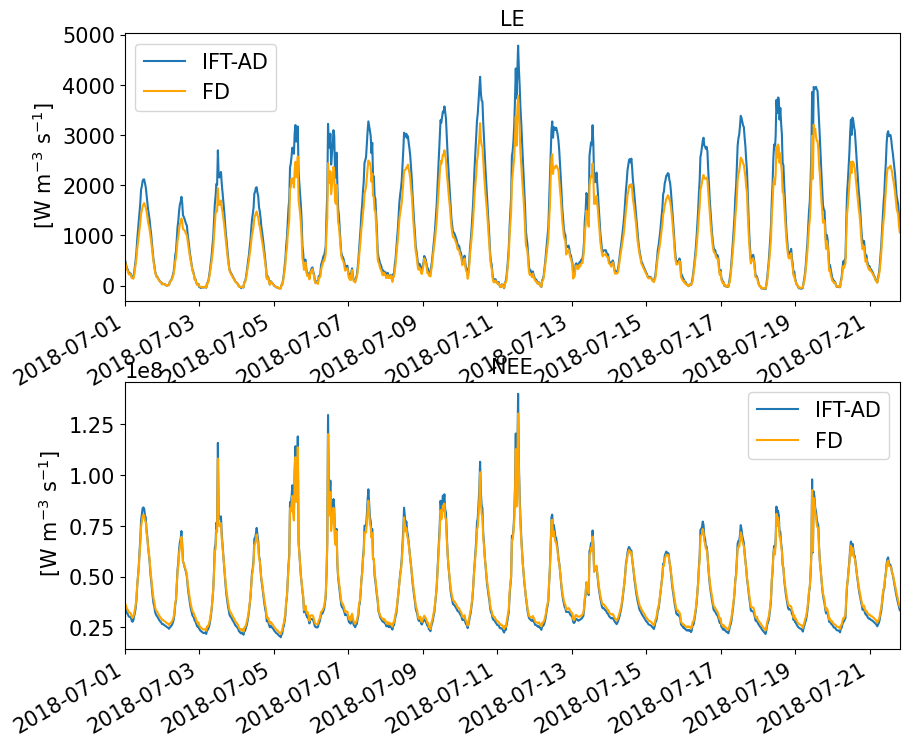

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
axes = axes.flatten()
for i, ax in enumerate(axes):
    title = update_get_labels[i]
    dir_grad_fd = dir_grad_fd_set[i]
    dir_grad_ad = dir_grad_ad_set[i]

    plot_timeseries(dir_grad_ad, timesteps, ax, title, "IFT-AD", "", color="tab:blue")
    plot_timeseries(dir_grad_fd, timesteps, ax, title, "FD", "", color="orange")
    ax.legend()
    ax.set(title=update_get_labels[i], ylabel=" [W m$^{-3}$ s$^{-1}$]", xlabel="")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
plt.subplots_adjust(hspace=0.3)

In [47]:
# # dir_grad_fd_batched = FD_directional_derivative_batched(para, batched_met_sa, canveg_eqx_ift, para_tangents, 1e-2)

# dir_grad_fd_set = []
# for para_tangents in tqdm(para_tangents_set):
#     dir_grad_fd = FD_directional_derivative_batched(para, batched_met_sa, canveg_eqx_ift, para_tangents, 1e-2)
#     dir_grad_fd_set.append(dir_grad_fd)

100%|██████████| 1/1 [00:14<00:00, 14.04s/it]


In [51]:
# fig, axes = plt.subplots(2, 1, figsize=(10,12), sharex=True)
# axes = axes.flatten()
# for i,ax in enumerate(axes):
#        subpara = subpara_set[i]
#        dir_grad_fd = dir_grad_fd_set[i]
#        dir_grad_ad = dir_grad_ad_set[i]

#        ax.plot(dir_grad_fd, label='FD')
#        ax.plot(dir_grad_ad, label='IFT-AD')
#        # ax.plot(dir_grad_ad-dir_grad_ad_set[i-1])
#        ax.legend()
#        # ax.set(ylim=[-1000, 30000], title=subpara, ylabel=' [W m$^{-3}$ s$^{-1}$]')
#        ax.set(title=subpara, ylabel=' [W m$^{-3}$ s$^{-1}$]')

# # ax = axes[1]
# # ax.plot(dir_grad_ad_batched - dir_grad_fd_batched)
# # ax.set(ylim=[-10000, 10000], ylabel='[W m$^{-3}$ s$^{-1}$]',
# #        xlabel='Time', yscale='linear', title='AD - FD');
# plt.subplots_adjust(hspace=0.3)

# Partial Derivative

In [14]:
start, ntime = 20, 1
met_onetime = jtu.tree_map(lambda x: x[start : start + ntime], met)

batched_met_sa = convert_met_to_batched_met(met, n_time, 1)

## AD

In [15]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canveg_le(para, met, canveg_eqx):
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    can_le = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)
    # met, update_soilresp, get_soilresp)
    return can_le.sum()


# @eqx.filter_jit
def df_canveg_le_batched(para, batched_met, canveg_eqx):
    def compute_grad(para, met):
        grad = df_canveg_le(para, met, canveg_eqx)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients

In [16]:
g_ad = df_canveg_le(para, met_onetime, canveg_eqx_ift)
g_ad.bprime

Array(1176.08701721, dtype=float64, weak_type=True)

In [17]:
jax.clear_caches()
gradients_ad = df_canveg_le_batched(para, batched_met_sa, canveg_eqx_ift)

In [ ]:
plt.plot(gradients_ad.bprime)

## FD

In [ ]:
# @eqx.filter_jit
def df_canveg_le_bprime_finite_diff(para, met, canveg_eqx, eps=None):
    # Compute out and tangents
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    out = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)
    # out = canveg_eqx(met)
    tangents = df_canveg_le(para, met, canveg_eqx)
    tangents_bprime = tangents.bprime

    # Get the eps
    max_leaves = [jnp.max(jnp.abs(p)) for p in jtu.tree_leaves(para)] + [1]
    scale = jnp.max(jnp.stack(max_leaves))
    if eps is None:
        ε = jnp.sqrt(jnp.finfo(jnp.float64).eps) * scale
    else:
        # Sometimes we may want to set it manually. finite_difference_jvp is actually
        # pretty inaccurate for nonlinear solves, as these are themselves often only
        # done to a tolerance of 1e-8 or so: the primal pass is already noisy at about
        # the scale of ε.
        ε = eps

    # Compute out_ε and tangents_ε
    bprime_ε = para.bprime + ε * tangents_bprime
    # para_ε = (ω(para) + ε * ω(tangents)).ω
    para_ε = eqx.tree_at(lambda x: x.bprime, para, bprime_ε)
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para_ε)
    out_ε = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)
    # out_ε = canveg_eqx(met)
    tangents_out = jtu.tree_map(
        lambda x, y: (x - y) / (ε * tangents_bprime), out_ε, out
    )
    # We actually return the perturbed primal.
    # This should still be within all tolerance checks, and means that we have aceesss
    # to both the true primal and the perturbed primal when debugging.
    # return out, out_ε, tangents_out
    return tangents_out


# @eqx.filter_jit
def df_canveg_le_batched_finite_diff(para, batched_met, canveg_eqx, eps=None):
    # if eps is not None: eps = jnp.array(eps)
    # def compute_grad(para, met):
    #     grad = df_canveg_le_bprime_finite_diff(para, met, canveg_eqx, eps)
    #     return para, grad
    gradients = []
    for i in range(n_time):
        bmet = jtu.tree_map(lambda x: x[i].reshape([1]), batched_met)
        g_fd = df_canveg_le_bprime_finite_diff(para, bmet, canveg_eqx, eps)
        gradients.append(g_fd)
    gradients = jnp.array(gradients)

    return gradients

In [ ]:
jax.clear_caches()
g_fd = df_canveg_le_bprime_finite_diff(para, met_onetime, canveg_eqx_ift, eps=1e-12)
g_fd

In [ ]:
jax.clear_caches()
gradients_fd_prime = df_canveg_le_batched_finite_diff(
    para, met, canveg_eqx_ift, eps=1e-12
)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax = axes[0]
ax.plot(gradients_fd_prime, label="FD")
ax.plot(gradients_ad.bprime, label="IFT-AD")
ax.legend()
ax.set(
    ylim=[-1000, 10000],
    title="$\partial LE / \partial g_0$",
    ylabel=" [W m$^{-3}$ s$^{-1}$]",
)

ax = axes[1]
ax.plot(gradients_ad.bprime - gradients_fd_prime.flatten())
ax.set(
    ylim=[-10000, 10000],
    ylabel="[W m$^{-3}$ s$^{-1}$]",
    xlabel="Time",
    yscale="linear",
    title="AD - FD",
)

plt.subplots_adjust(hspace=0.3)

# Directional derivatives

In [ ]:
# Define directional vector for the parameters of interest
para_tangents = jtu.tree_map(lambda _: 0.0, para)
para_tangents = eqx.tree_at(
    lambda t: (
        t.bprime,
        t.ep,
        t.lleaf,
        t.qalpha,
        t.kball,
        t.leaf_clumping_factor,
    ),
    para_tangents,
    replace=(
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
    ),
)
# para_tangents = jtu.tree_map(lambda p,t: p+t, para, para_tangents)

## AD

In [ ]:
# @jax.jit
@eqx.filter_jit
def tree_dot(a, b):
    """
    Computes the dot product of two pytrees
    Args:
        a, b: pytrees with the same treedef
    Returns:
        A scalar equal the dot product of of the flattened arrays of a and b.
    """
    return jax.tree_util.tree_reduce(
        jax.numpy.add,
        jax.tree_util.tree_map(
            jax.numpy.sum, jax.tree_util.tree_map(jax.numpy.multiply, a, b)
        ),
    )

In [ ]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canveg_le(para, met, canveg_eqx):
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    can_le = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)
    return can_le.sum()


def AD_directional_derivative(para, met, canveg_eqx, para_tangents):
    gradient = df_canveg_le(para, met, canveg_eqx)
    dir_grad = tree_dot(gradient, para_tangents)
    return dir_grad


# @eqx.filter_jit
def AD_directional_derivative_batched(para, batched_met, canveg_eqx, para_tangents):
    def compute_grad(para, met):
        grad = AD_directional_derivative(para, met, canveg_eqx, para_tangents)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients

In [ ]:
dir_grad_ad = AD_directional_derivative(
    para, met_onetime, canveg_eqx_ift, para_tangents
)
dir_grad_ad

In [ ]:
dir_grad_ad_batched = AD_directional_derivative_batched(
    para, batched_met_sa, canveg_eqx_ift, para_tangents
)

## FD

In [ ]:
def FD_directional_derivative(para, met, canveg_eqx, para_tangents, h=1e-2):
    # assert jax.config.jax_enable_x64  # pyright: ignore
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    out = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)

    # Choose ε to trade-off truncation error and floating-point rounding error.
    para_h = (ω(para) + h * ω(para_tangents)).ω
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para_h)
    out_h = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)
    dir_grad = jtu.tree_map(lambda x, y: (x - y) / h, out_h, out)
    # tangents_out = jtu.tree_map(lambda x, y: (x - y) / h, out_h, out)
    # We actually return the perturbed primal.
    # This should still be within all tolerance checks, and means that we have aceesss
    # to both the true primal and the perturbed primal when debugging.
    return dir_grad


def FD_directional_derivative_batched(
    para, batched_met, canveg_eqx, para_tangents, h=1e-2
):
    gradients = []
    for i in range(n_time):
        bmet = jtu.tree_map(lambda x: x[i].reshape([1]), batched_met)
        g_fd = FD_directional_derivative(para, bmet, canveg_eqx, para_tangents, h)
        gradients.append(g_fd)
    gradients = jnp.array(gradients)

    return gradients.flatten()

In [ ]:
dir_grad_fd = FD_directional_derivative(
    para, met_onetime, canveg_eqx_ift, para_tangents, 1e-10
)
dir_grad_fd

In [ ]:
dir_grad_fd_batched = FD_directional_derivative_batched(
    para, met, canveg_eqx_ift, para_tangents, 1e-2
)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
ax = axes[0]
ax.plot(dir_grad_fd_batched, label="FD")
ax.plot(dir_grad_ad_batched, label="IFT-AD")
ax.legend()
ax.set(
    ylim=[-1000, 10000], title="Directional derivative", ylabel=" [W m$^{-3}$ s$^{-1}$]"
)

ax = axes[1]
ax.plot(dir_grad_ad_batched - dir_grad_fd_batched)
ax.set(
    ylim=[-10000, 10000],
    ylabel="[W m$^{-3}$ s$^{-1}$]",
    xlabel="Time",
    yscale="linear",
    title="AD - FD",
)

plt.subplots_adjust(hspace=0.3)

In [ ]:
# Compare AD and FD with different scale h
h_set = [1e-2, 1e-5, 1e-10, 1e-12]
dir_grad_fd_batched_set = []
for h in h_set:
    dir_grad = FD_directional_derivative_batched(
        para, met, canveg_eqx_ift, para_tangents, h
    )
    dir_grad_fd_batched_set.append(dir_grad)

In [ ]:
# Choose an existing colormap, e.g., 'viridis'
import numpy as np

cmap = plt.get_cmap("Blues")
gradient_values = np.linspace(0, 1, len(h_set))
colors = cmap(gradient_values)

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
ax = axes[0]
ax.plot(dir_grad_ad_batched, label="IFT-AD", color="k")
for i, dir_grad in enumerate(dir_grad_fd_batched_set[:-1]):
    h = h_set[i]
    ax.plot(dir_grad, label=f"FD (step: {h})", color=colors[i])
ax.legend()
ax.set(
    ylim=[-1000, 10000], title="Directional derivative", ylabel=" [W m$^{-3}$ s$^{-1}$]"
)

ax = axes[1]
# ax.plot(dir_grad_ad_batched - dir_grad_fd_batched)
for i, dir_grad in enumerate(dir_grad_fd_batched_set[:-1]):
    h = h_set[i]
    ax.plot(dir_grad_ad_batched - dir_grad, label=f"FD (step: {h})", color=colors[i])
ax.legend()
ax.set(
    ylim=[-10000, 10000],
    ylabel="[W m$^{-3}$ s$^{-1}$]",
    xlabel="Time",
    yscale="linear",
    title="AD - FD",
)

plt.subplots_adjust(hspace=0.3)

# Backup

In [ ]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np

jax.config.update("jax_enable_x64", True)

In [ ]:
jnp.finfo(jnp.float64).eps

## Patrick's version

In [ ]:
def finite_difference_jvp(fn, primals, tangents, eps=None, **kwargs):
    assert jax.config.jax_enable_x64  # pyright: ignore
    out = fn(*primals, **kwargs)
    # Choose ε to trade-off truncation error and floating-point rounding error.
    max_leaves = [jnp.max(jnp.abs(p)) for p in jtu.tree_leaves(primals)] + [1]
    scale = jnp.max(jnp.stack(max_leaves))
    if eps is None:
        ε = np.sqrt(np.finfo(np.float64).eps) * scale
    else:
        # Sometimes we may want to set it manually. finite_difference_jvp is actually
        # pretty inaccurate for nonlinear solves, as these are themselves often only
        # done to a tolerance of 1e-8 or so: the primal pass is already noisy at about
        # the scale of ε.
        ε = eps
    with jax.numpy_dtype_promotion("standard"):
        primals_ε = (ω(primals) + ε * ω(tangents)).ω
        out_ε = fn(*primals_ε, **kwargs)
        tangents_out = jtu.tree_map(lambda x, y: (x - y) / ε, out_ε, out)
    # We actually return the perturbed primal.
    # This should still be within all tolerance checks, and means that we have aceesss
    # to both the true primal and the perturbed primal when debugging.
    return out_ε, tangents_out

## Toshi's version

In [ ]:
# create random vector that has the same shape as the input parameters
# this function is from https://github.com/google/jax/discussions/9508
def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jtu.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jtu.tree_unflatten(treedef, keys)


def tree_random_normal_like(rng_key, target):
    keys_tree = random_split_like_tree(rng_key, target)
    return jtu.tree_map(
        lambda l, k: jrandom.normal(k, l.shape, l.dtype),
        target,
        keys_tree,
    )


# finite difference check for the gradient of a function
def check_gradient(fun, x_0, n_eps=32, verbose=False):
    grad_fun = grad(fun)
    y_0 = fun(x_0)
    dy_0 = grad_fun(x_0)

    step_struct = jax.eval_shape(lambda: x_0)
    step = tree_random_normal_like(jrandom.PRNGKey(0), step_struct)
    dir_grad0 = tree_dot(dy_0, step)  # directional derivative

    eps = 1.0e-2 * jnp.power(2.0, -jnp.arange(n_eps))

    def FD_approximation(carry, eps):
        x_0, y_0, dir_grad0, step = carry
        x_step = (eps * step**ω).ω
        x_1 = (x_0**ω + x_step**ω).ω
        x_2 = (x_0**ω - x_step**ω).ω

        y_1 = fun(x_1)
        y_2 = fun(x_2)
        error = abs((y_1 - y_0) / eps - dir_grad0)
        error_2 = abs((y_1 - y_2) / (2.0 * eps) - dir_grad0)
        carry = x_0, y_0, dir_grad0, step
        if verbose:
            jax.debug.print(
                "For eps = {eps}, the error for the first-order and second order FD is {error} and {error_2}, respectively.",
                eps=eps,
                error=error,
                error_2=error_2,
            )
        return carry, (error, error_2)

    init_carry = (x_0, y_0, dir_grad0, step)
    carry, output = lax.scan(FD_approximation, init_carry, eps)
    return eps, output